In [1]:
import emcee
import numpy as np
from scipy import stats
import chainconsumer 
import matplotlib.pyplot as plt
from scipy.integrate import quad
from chainconsumer import ChainConsumer

%config InlineBackend.figure_format = 'svg'

In [2]:
# Load table
csv_table = np.loadtxt('data.csv', skiprows=1, delimiter=',', dtype='S', usecols=(1, 2, 3))


redshifts = csv_table[:, 0].astype(np.float) # redshifts

f_gas_colSCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 1]]) # SCDM column
f_gas_SCDM, sigma_SCDM = f_gas_colSCDM[:, 0], f_gas_colSCDM[:, 1]

f_gas_colLambdaCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 2]]) # LambdaCDM column
f_gas_LambdaCDM, sigma_LambdaCDM = f_gas_colLambdaCDM[:, 0], f_gas_colLambdaCDM[:, 1]

# Create dictionary from table data
data = {}
data['z'] = redshifts
data['f_gas_SCDM'] = f_gas_SCDM
data['sigma_SCDM'] = sigma_SCDM

data['f_gas_LambdaCDM'] = f_gas_LambdaCDM
data['sigma_LambdaCDM'] = sigma_LambdaCDM

In [3]:
# # Print data as a table
# print('z          f_gas_SCDM     f_gas_LambdaCDM')

# for i in range(len(data['z'])):
#     print('{}     {}+/-{}     {}+/-{}'.format(data['z'][i], data['f_gas_SCDM'][i], data['sigma_SCDM'][i], 
#                                           data['f_gas_LambdaCDM'][i], data['sigma_LambdaCDM'][i]))

In [4]:
z, f_gas, f_gas_sigma = data['z'], data['f_gas_SCDM'], data['sigma_SCDM']


In [6]:
def E_z(z, pars):
    omega_m = pars['omega_m']
    omega_X = pars['omega_X']
    omega_K = pars['omega_K']
    w_X = pars['w_X']
    f_z = (1+z)**(3*(1+w_X))
    return np.sqrt(omega_m*(1+z)**3 + omega_X*f_z + omega_K*(1+z)**2)

def one_over_E_z(z, pars):
    return 1/E_z(z, pars)

def d_A(z, pars):
    H0 = pars['h']*100
    
    c = 299792.458 # c in km/s
    
    integral = quad(one_over_E_z, 0, z, args=(pars))[0]
    if pars['omega_K']==0.:
        pre_factor = c/(H0*(1+z))
        return pre_factor*integral
    if pars['omega_K']>0.:
        pre_factor = c/(H0*(1+z)*pars['omega_K']**0.5)
        return pre_factor*np.sinh(pars['omega_K']**0.5*integral)
    if pars['omega_K']<0.:
        pre_factor = c/(H0*(1+z)*np.abs(pars['omega_K'])**0.5)
        return pre_factor*np.sin(np.abs(pars['omega_K'])**0.5*integral)


def f_model(z, pars):
    '''
    SCDM cosmology: omega_m = 1., h=0.5, omega_K=omega_X=0
    '''
    d_SCDM = d_A(z, {'omega_m':1., 'omega_X':0., 'omega_K':0., 'h':0.5, 'w_X':-1}) #reference cosmology 1
#     d_lambdaCDM = d_A(z, omega_m=.3, omega_X=0.7, omega_K=0., h=0.7, w_X=-1) #reference cosmology 2
    
    d_model = d_A(z, pars)
    
    return pars['b']*pars['omega_b']/((1 + 0.19*pars['h']**0.5)*pars['omega_m']) * (d_SCDM/d_model)**1.5
    

def log_prior(pars, names):
    '''
    Input: 
        pars: Parameter dictionary 
        names: list of fit parameters
    Output: np.inf if parameter value out of bounds
            else Gaussian parameter prior
    '''
    count = 0
    for name in names:
        limits = parameter_limits[name]
        low, high = limits[0], limits[1]
        if pars[name]< low or pars[name]>high:
            count+=1
    if count!=0:
        return -np.inf
    else : 
        prior = 0
        if 'omega_b' in names:
            prior +=((pars['omega_b']*pars['h']**2-0.0214)/0.002)**2
            
        if 'h' in names:
            prior += ((pars['h']-0.72)/0.08)**2 
        if 'b' in names:
            prior += ((pars['b']-0.824)/0.089)**2
        return  prior
    
    
    
def log_likelihood(fit_par_values, fit_par_names, flat):
    # f_gas data
    z, f_gas, f_gas_sigma = data['z'], data['f_gas_SCDM'], data['sigma_SCDM']
    
    pars = get_default_parameters()
    
    for par_value, par_name in zip(fit_par_values, fit_par_names):
        pars[par_name] = par_value
    
    if not np.isfinite(log_prior(pars, fit_par_names)):
        return -np.inf
    
    else:
        log_likelihood = 0.
        
        if flat==True:
            pars['omega_X'] = 1 - pars['omega_m']
            pars['omega_K'] = 0.
        else:
            pars['omega_K'] = 1 - pars['omega_m'] - pars['omega_X']


        for  z_i, f_gas_i, f_gas_sigma_i in zip(z, f_gas, f_gas_sigma):        
            f_gas_model = f_model(z_i, pars)
            log_likelihood += (f_gas_i - f_gas_model)**2/(f_gas_sigma_i)**2

            return -log_likelihood - log_prior(pars, fit_par_names)
    

In [7]:
def get_default_parameters(update=None):
    pars = {}
    pars['omega_m'] = 0.26
    pars['omega_X'] = 0.73
    pars['omega_K'] = 0.0
    pars['omega_b'] = 0.041
    pars['h'] = 0.72
    pars['w_X'] = -1
    pars['b'] = 0.824
    if update is not None:
        pars.update(update)
    return pars

def get_starting_point(name_list):
    sp = {}
    sp['omega_m'] = 0.28
    sp['omega_X'] = 0.72
    sp['omega_K'] = 0.01
    sp['omega_b'] = 0.05
    sp['h'] = 0.72
    sp['w_X'] = -1
    sp['b'] = 0.8
    
    return np.array([sp[x] for x in name_list])
    
    
    
def get_latex_names(name_list):
    latex_names = {}
    latex_names['omega_m'] = '$\Omega_m$'
    latex_names['omega_X'] = '$\Omega_X$'
    latex_names['omega_K'] = '$\Omega_K$'
    latex_names['omega_b'] = '$\Omega_b$'
    latex_names['h'] = 'h'
    latex_names['w_X'] = '$w_X$'
    latex_names['b'] = 'b'
    
    return [latex_names[x] for x in name_list]

def run_mcmc(fit_par_names, flat=True):
    pars = get_default_parameters()
    starting_point = get_starting_point(fit_par_names)
    std = 0.2*starting_point
    ndim = len(fit_par_names)
    nwalkers = 32

    p0 = emcee.utils.sample_ball(starting_point, std, size=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[fit_par_names, flat])
    sampler.run_mcmc(p0, 20000, progress=True);
    samples = sampler.get_chain(discard=10000, flat=True)

    if flat==True and 'omega_m' in fit_par_names:
        print('first one')

        samples_new = np.column_stack((1-samples[:,0], samples))
        
    elif flat==False and 'omega_m' in fit_par_names:
        print('second one')
        try:
            samples_new = np.column_stack((1-samples[:,fit_par_names.index('omega_m')]-
                                           samples[:,fit_par_names.index('omega_X')], samples))
        except:
            samples_new = np.column_stack((1-samples[:,fit_par_names.index('omega_m')]-
                                           pars['omega_X'], samples))

    else:
        samples_new = samples
    return samples_new
    
parameter_limits={
    'omega_m' : [0., 1.],
    'omega_X' : [0., 2.],
    'omega_K' : [-2, 2.],
    'omega_b' : [-2., 2.],
    'h'       : [.2, 1.],
    'w_X'     : [-5., 5],
    'b'       : [0., 1.]
    }



In [8]:
fit_par_names = ['omega_m', 'omega_b', 'h', 'b']

chain = run_mcmc(fit_par_names, flat=True)

  0%|          | 0/20000 [00:00<?, ?it/s]/home/pranjalrs/miniconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [01:03<00:00, 312.88it/s]

first one


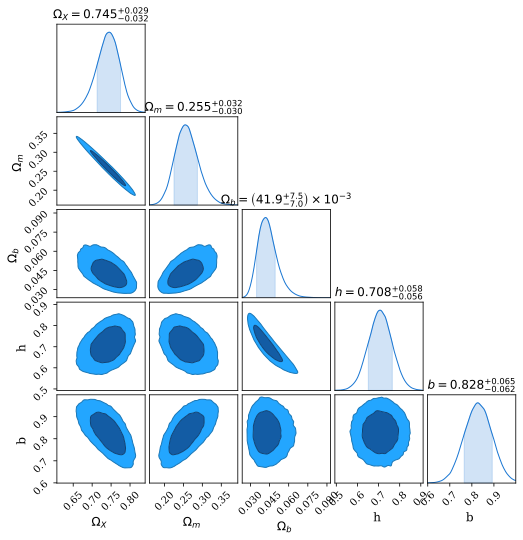

In [9]:
par_names_latex = get_latex_names(['omega_X']+fit_par_names)


c = ChainConsumer().add_chain(chain, parameters=par_names_latex).configure(statistics="max", summary=True,usetex=False)
fig = c.plotter.plot()


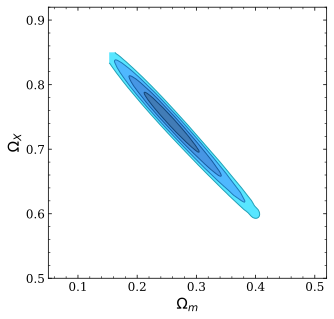

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(labelsize=12., grid_linewidth=10)
ax.set_xlabel('$\Omega_m$', fontsize=15)
ax.set_ylabel('$\Omega_X$', fontsize=15)
ax.set_ylim([0.5, 0.92])
ax.set_xlim([0.05, 0.52])
ax.set_yticks(np.arange(0.5, 0.92, 0.1))

c2 = ChainConsumer().add_chain(chain[:,0:2], parameters=['$\Omega_X$', '$\Omega_m$'], shade_alpha=0.8).configure(statistics="max", summary=True,usetex=False, sigmas=[1, 2, 3, 4])
c2.plotter.plot_contour(ax, '$\Omega_m$', '$\Omega_X$')

plt.show()

In [11]:
# import astropy.cosmology as cosmo
import astropy.units as u
cosm = cosmo.wCDM(H0=69.6*u.km / u.s / u.Mpc, Om0=0.3, Ode0=0.7, w0=-100)
cosm.angular_diameter_distance(0.9)

NameError: name 'cosmo' is not defined

In [ ]:
d_A(z=0.9, pars={'omega_m':0.3, 'omega_X':0.7, 'omega_K':0.0, 'h':0.696, 'w_X':-100})